In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cosine

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')
adjusted_score_df = pd.read_csv('data/adjusted_score_df.csv', index_col='id')

In [3]:
binary_df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
binary_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
rank_df = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
rank_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [5]:
sim_mat = cosine_similarity(rank_df.values)

In [18]:
adjusted_score_df['adjusted_score']

id
10161     0.650287
99726     0.692942
98526     0.522631
966       0.658964
4876      0.549320
            ...   
99586     0.590663
99916     0.688089
101283    0.612901
101633    0.668539
101089    0.000000
Name: adjusted_score, Length: 9832, dtype: float64

In [17]:
x = (adjusted_score_df['adjusted_score'] ** 2)
x /= max(x)
x

id
10161     0.524962
99726     0.596090
98526     0.339085
966       0.539065
4876      0.374601
            ...   
99586     0.433109
99916     0.587770
101283    0.466336
101633    0.554845
101089    0.000000
Name: adjusted_score, Length: 9832, dtype: float64

In [19]:
adjusted_scores = round(x, 4)
adjusted_scores

id
10161     0.5250
99726     0.5961
98526     0.3391
966       0.5391
4876      0.3746
           ...  
99586     0.4331
99916     0.5878
101283    0.4663
101633    0.5548
101089    0.0000
Name: adjusted_score, Length: 9832, dtype: float64

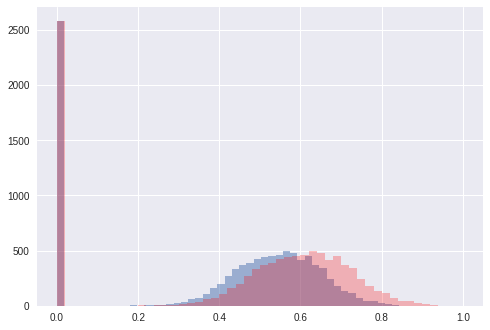

In [8]:
plt.hist(adjusted_score_df['adjusted_score'], bins=50, alpha=.5)
plt.hist(adjusted_scores, bins=50, alpha=.25, color='red');

In [9]:
weighted_sim_mat = (sim_mat * adjusted_scores.to_numpy())
weighted_sim_mat

array([[0.7245    , 0.        , 0.29347532, ..., 0.        , 0.11280975,
        0.        ],
       [0.        , 0.7721    , 0.        , ..., 0.04025339, 0.17317461,
        0.        ],
       [0.36514317, 0.        , 0.5823    , ..., 0.        , 0.16219698,
        0.        ],
       ...,
       [0.        , 0.04551126, 0.        , ..., 0.6829    , 0.        ,
        0.        ],
       [0.10972032, 0.17949807, 0.12679192, ..., 0.        , 0.7449    ,
        0.        ],
       [0.        , 0.27693419, 0.        , ..., 0.03013517, 0.25928979,
        0.        ]])

In [10]:
def get_anime_id(_user_preferred_title):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([_user_preferred_title])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_user_preferred(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, binary_df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [11]:
def get_recommendations(search_term, similarity_matrix=weighted_sim_mat):
    user_preferred_title = get_user_preferred(search_term)
    _id = get_anime_id(user_preferred_title)
    print('Getting recommendations for: ', get_title_from_id(_id))
    rec_list = get_top_n_recommendations(_id, 
                                         rank_df, 
                                         similarity_matrix, 
                                         n=5)
    return rec_list



In [12]:
get_top_n_recommendations(get_anime_id(get_user_preferred("Wolf's Rain")), rank_df, weighted_sim_mat, n=25)

['They Were 11',
 'One Piece Film: Strong World',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'One Piece: Episode of Merry - The Tale of One More Friend',
 'Final Fantasy VII: Advent Children - Venice Film Festival Footage',
 'Pokémon: Mewtwo Returns',
 'Planetarian',
 'Made in Abyss: Wandering Twilight',
 'Saiyuuki Reload: Burial',
 'Modest Heroes: Ponoc Short Films Theatre, Volume 1',
 'Grimgar of Fantasy and Ash',
 'No Game, No Life Zero',
 'Chrome Shelled Regios',
 'Pokémon: Lucario and the Mystery of Mew',
 'Mujin Wakusei Survive',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Kingsglaive Final Fantasy XV',
 'Final Fantasy VII: Last Order',
 'Attack on Titan',
 'Land of the Lustrous',
 'Tsubasa: Spring Thunder Chronicles',
 'Attack on Titan Season 2',
 'Nausicaä of the Valley of the Wind',
 "Wolf's Rain OVA",
 'Made in Abyss']

In [13]:
get_top_n_recommendations(get_anime_id(get_user_preferred("Wolf's Rain")), rank_df, sim_mat, n=25)

['Pokémon: Mewtwo Returns',
 'Xia Lan',
 'They Were 11',
 'Dances with the Dragons',
 'Modest Heroes: Ponoc Short Films Theatre, Volume 1',
 'Tsubasa: Spring Thunder Chronicles',
 'The Laws of the Universe - Part I',
 'AOTU Shijie',
 'Rokka: Braves of the Six Flowers Picture Drama',
 'AOTU Shijie 2',
 'Owari no Chronicle',
 'Final Fantasy VII: Advent Children - Venice Film Festival Footage',
 'Mushrambo (2008)',
 'Kurogane Communication',
 'Hi no Tori 2772: Ai no CosmoZone',
 'Ancien to Mahou no Tablet: Mou Hitotsu no Hirune Hime',
 'Shen Qi Huan Qi Tan',
 'Chrome Shelled Regios',
 'Pokémon: Lucario and the Mystery of Mew',
 'Kingsglaive Final Fantasy XV',
 'Wan Wan Chuushingura',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

In [64]:
get_anime_id('Made in Abyss')

97986

In [37]:
view_features_from_id(get_anime_id('Made in Abyss'), rank_df)

{'adventure',
 'amnesia',
 'body_horror',
 'chibi',
 'drama',
 'dungeon',
 'fantasy',
 'female_protagonist',
 'gore',
 'lost_civilization',
 'monster_girl',
 'mystery',
 'primarily_child_cast',
 'robots',
 'sci_fi',
 'seinen',
 'survival',
 'tragedy'}

In [38]:
view_features_from_id(get_anime_id("Wolf's Rain"), rank_df)

{'action',
 'adventure',
 'animals',
 'drama',
 'dystopian',
 'fantasy',
 'mystery',
 'post_apocalyptic',
 'primarily_adult_cast',
 'sci_fi',
 'survival',
 'tragedy',
 'werewolf'}

In [ ]:
# list of titles to list of ids
title_list = ["Wolf's Rain"]
id_list = []
for title in title_list:
    user_preferred_title = get_user_preferred(title)
    id_list.append(get_anime_id(user_preferred_title))
    print(user_preferred_title)

In [ ]:
rank_df.loc[id_list,:]

In [ ]:
# get the mean vector for a list of anime
mean_vector = rank_df.loc[id_list,:].mean(axis=0)
mean_vector

In [ ]:
# measure the cosine similarity between our mean vector and every item in our dataset
dist_list = []
for anime in rank_df.iterrows():
    dist_list.append(cosine(mean_vector, anime[1]))
dist_series = pd.Series(dist_list, index=rank_df.index)

In [ ]:
dist_series

In [ ]:
title_list

In [ ]:
# USING AVERAGE FEATURE VECTOR TO FIND MOST SIMILAR ELEMENTS IN A SIMILARITY MATRIX
# get the titles for our ids
for num, _id in enumerate(list(dist_series.sort_values()[:30].index)):
    print(num+1, get_title_from_id(_id))